## NHANES - DATA Ingestion and Data Cleaning and Data Wrangling

- Load raw datasets (raw datasets with specific column fields) and save as interim csv file.
- Explore interim raw data 
- Clean datasets
- Explore cleaned data
- Save cleaned datasets 
- Done feature engineering
- Save processed datasets

## 1. Import required Libraries

#### Prepares the environment by importing key libraries, adjusting paths, and setting up project-specific configurations.

In [1]:
# 1. Setup environment and imports
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

# Add the 'scripts' folder to the Python path
scripts_path = Path("../scripts").resolve()
if str(scripts_path) not in sys.path:
    sys.path.append(str(scripts_path))

# Import custom modules
from data_loading import process_datasets 
from data_cleaning import clean_datasets
from config import PROCESSED_DATA_DIR, ensure_directories, PLOTS_DIR

# Ensure all necessary directories exist
ensure_directories()

# Import helper Functions
from utils import explore_data , pretty_path

print("Setup complete.")

Project directories are ready.
Setup complete.


## 2. DATA INGESTION

### STEP 1:  Load raw NHANES datasets with specific columns and saved it in interim csv file

In [2]:
# Load raw NHANES datasets
print("Loading raw datasets...")
interim_data =  process_datasets()

# raw_data is a dictionary of DataFrames keyed by dataset name
print(f"Loaded raw datasets: {list(interim_data.keys())}") 

Loading raw datasets...
Starting dataset validation...
File found for: DEMO_L
Successfully read DEMO_L with pandas. Rows: 11933
File found for: PAQ_L
Successfully read PAQ_L with pandas. Rows: 8153
File found for: SLQ_L
Successfully read SLQ_L with pandas. Rows: 8501
File found for: DR1TOT_L
Successfully read DR1TOT_L with pandas. Rows: 8860
File found for: HIQ_L
Successfully read HIQ_L with pandas. Rows: 11933
File found for: BMX_L
Successfully read BMX_L with pandas. Rows: 8860
File found for: BPXO_L
Successfully read BPXO_L with pandas. Rows: 7801
File found for: TCHOL_L
Successfully read TCHOL_L with pandas. Rows: 8068
File found for: GLU_L
Successfully read GLU_L with pandas. Rows: 3996
File found for: DIQ_L
Successfully read DIQ_L with pandas. Rows: 11744
File found for: MCQ_L
Successfully read MCQ_L with pandas. Rows: 11744
All dataset files validated successfully.

Loading dataset: DEMO_L
Saved interim CSV for DEMO_L to data\interim\demo_l_interim.csv

Loading dataset: PAQ_L
Sa

### STEP 2: Explore interim raw data

In [3]:
# Explore interim raw data 
print("Exploring interim raw datasets...")
explore_data(interim_data)

Exploring interim raw datasets...

--- Exploring DEMO_L ---
Shape: (11933, 10)

First 5 rows:
       SEQN  RIAGENDR  RIDAGEYR  RIDRETH3  DMDEDUC2  INDFMPIR      WTINT2YR  \
0  130378.0       1.0      43.0       6.0       5.0      5.00  50055.450807   
1  130379.0       1.0      66.0       3.0       5.0      5.00  29087.450605   
2  130380.0       2.0      44.0       2.0       3.0      1.41  80062.674301   
3  130381.0       2.0       5.0       7.0       NaN      1.53  38807.268902   
4  130382.0       1.0       2.0       3.0       NaN      3.60  30607.519774   

       WTMEC2YR  SDMVSTRA  SDMVPSU  
0  54374.463898     173.0      2.0  
1  34084.721548     173.0      2.0  
2  81196.277992     174.0      1.0  
3  55698.607106     182.0      2.0  
4  36434.146346     182.0      2.0  

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11933 entries, 0 to 11932
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      

## 3.Data Cleaning

### STEP 1:  Clean the Data 

In [4]:
# Clean interim raw datasets
print("Cleaning datasets...")
cleaned_data = clean_datasets(interim_data)
print(f"Cleaned datasets: {list(cleaned_data.keys())}")

Cleaning datasets...
Cleaning dataset: DEMO_L
Cleaning process begins
DEMO_L dataset rows and columns before cleaning: (11933, 10)
Dropped rows with missing age...
Removed people under 20 years old...
Dropping rows missing gender, race, strata, or PSU...
Mapping gender, race, and education level to text...
Replacing weird tiny float values (e.g., 5.39e-79) with NaN...
Imputing missing poverty_income_ratio (PIR) within education_level + race_ethnicity groups...
Imputed PIR: 1388 filled, 0 still missing
Removing missing and invalid sample weights
Checking for missing interview sample weight...
DEMO_L dataset rows and columns after cleaning: (6064, 11)
Saved cleaned data to: data\clean\demo_l_clean.csv
Cleaning dataset: SLQ_L
Cleaning SLQ_L dataset begins
Dataframe shape before cleaning: (8501, 3)
Missing values before cleaning:
Missing values in dataset: SLQ_L
participant_id        0
sleep_weekday_hr    113
sleep_weekend_hr    114
dtype: int64
Validating sleep hour values...
Calculating 

### STEP 2: Explore cleaned data

In [5]:
# Explore cleaned data 
print("Exploring cleaned datasets...")
explore_data(cleaned_data)

Exploring cleaned datasets...

--- Exploring DEMO_L ---
Shape: (6064, 11)

First 5 rows:
  participant_id  gender  age      race_ethnicity            education_level  \
0         130378    Male   43  Non-Hispanic Asian  College graduate or above   
1         130379    Male   66  Non-Hispanic White  College graduate or above   
2         130380  Female   44      Other Hispanic            High school/GED   
8         130386    Male   34    Mexican American     Some college/AA degree   
9         130387  Female   68  Non-Hispanic White  College graduate or above   

   poverty_income_ratio  interview_sample_weight  exam_sample_weight  strata  \
0                  5.00             50055.450807        54374.463898   173.0   
1                  5.00             29087.450605        34084.721548   173.0   
2                  1.41             80062.674301        81196.277992   174.0   
8                  1.33             30995.282610        39988.452940   179.0   
9                  1.32       

## 4. Data Wrangling

### STEP 1: Feature Engineering

#### This function takes cleaned datasets and adds new, useful columns (features) to help with analysis or modeling later on. These new features are based on health, diet, activity, and medical information.

In [6]:
# Feature engineering

# Import functions
from feature_engineering import (
    compute_diet_score, categorize_activity_level,
    categorize_sleep, get_pir_category, label_diet_score, flag_obesity, categorize_bp,
    cholesterol_category, glucose_category, glucose_flags, engineer_diq_features, engineer_mcq_features
)
def engineer_features(cleaned_data):
    if 'DEMO_L' in cleaned_data and not cleaned_data['DEMO_L'].empty:
        cleaned_data['DEMO_L']["pir_category"] = cleaned_data['DEMO_L']["poverty_income_ratio"].apply(get_pir_category)

    if 'DR1TOT_L' in cleaned_data and not cleaned_data['DR1TOT_L'].empty:
        cleaned_data['DR1TOT_L']['diet_score'] = cleaned_data['DR1TOT_L'].apply(compute_diet_score, axis=1)
        cleaned_data['DR1TOT_L']['diet_category'] = cleaned_data['DR1TOT_L']['diet_score'].apply(label_diet_score)

    if 'PAQ_L' in cleaned_data and not cleaned_data['PAQ_L'].empty:
        cleaned_data['PAQ_L']['activity_level'] = cleaned_data['PAQ_L']['total_weekly_min'].apply(categorize_activity_level)

    if 'SLQ_L' in cleaned_data and not cleaned_data['SLQ_L'].empty:
        cleaned_data['SLQ_L']['sleep_category'] = cleaned_data['SLQ_L']['sleep_avg_hr'].apply(categorize_sleep)

    if 'BPXO_L' in cleaned_data and not cleaned_data['BPXO_L'].empty:
        cleaned_data['BPXO_L']['bp_category'] = cleaned_data['BPXO_L'].apply(
            lambda row: categorize_bp(row['systolic_avg'], row['diastolic_avg']), axis=1
        )

    if 'BMX_L' in cleaned_data and not cleaned_data['BMX_L'].empty:
        cleaned_data['BMX_L']['obese'] = cleaned_data['BMX_L']['bmi'].apply(flag_obesity).astype(int)

    if 'TCHOL_L' in cleaned_data and not cleaned_data['TCHOL_L'].empty:
        cleaned_data['TCHOL_L']['cholesterol_category'] = cleaned_data['TCHOL_L']['total_cholesterol'].apply(cholesterol_category)

    if 'GLU_L' in cleaned_data and not cleaned_data['GLU_L'].empty:
        df_glu = cleaned_data['GLU_L'].copy()
        
        # Add glucose category
        df_glu['glucose_category'] = df_glu['fasting_glucose_mg_dl'].apply(glucose_category)
        
        # Compute flags only once
        flags_df = df_glu['fasting_glucose_mg_dl'].apply(glucose_flags).apply(pd.Series)
        flags_df.columns = ['hypoglycemia_flag', 'hyperglycemia_flag']
        
        # Drop existing flag columns if they exist (to avoid duplicates)
        df_glu = df_glu.drop(columns=[col for col in df_glu.columns if col in ['hypoglycemia_flag', 'hyperglycemia_flag']], errors='ignore')
        
        # Concatenate cleanly
        df_glu = pd.concat([df_glu, flags_df], axis=1)
        
        # Add log column
        df_glu['log_fasting_glucose_mg_dl'] = np.log(df_glu['fasting_glucose_mg_dl'].clip(lower=1))
        
        # Assign back
        cleaned_data['GLU_L'] = df_glu

     # Add diabetes features if 'DIQ_L' dataframe exists
    if 'DIQ_L' in cleaned_data and not cleaned_data['DIQ_L'].empty:
        cleaned_data['DIQ_L'] = engineer_diq_features(cleaned_data['DIQ_L'])

    # Add cardiovascular disease features if 'MCQ_L' dataframe exists
    if 'MCQ_L' in cleaned_data and not cleaned_data['MCQ_L'].empty:
        cleaned_data['MCQ_L'] = engineer_mcq_features(cleaned_data['MCQ_L'])

    return cleaned_data


In [7]:
# Calling feature engineering 
print(" Engineering features...")
processed_data = engineer_features(cleaned_data)
print(f"Processed datasets: {list(processed_data.keys())}")

 Engineering features...
Processed datasets: ['DEMO_L', 'SLQ_L', 'PAQ_L', 'DR1TOT_L', 'HIQ_L', 'BMX_L', 'BPXO_L', 'TCHOL_L', 'GLU_L', 'DIQ_L', 'MCQ_L']


### STEP 2: Save processed data

#### This script saves multiple processed datasets to .csv files in a specified folder

In [8]:
#  Save processed data

def save_processed_data(processed_data: dict, folder_path=PROCESSED_DATA_DIR):
    folder_path.mkdir(parents=True, exist_ok=True) 

    for key, df in processed_data.items():
        file_path = folder_path / f"{key.lower()}_processed.csv"
        df.to_csv(file_path, index=False)
        print(f"Saved: {pretty_path(file_path)}")
print("Saving processed data...")
save_processed_data(processed_data)
print("All data saved.")


Saving processed data...
Saved: data\processed\demo_l_processed.csv
Saved: data\processed\slq_l_processed.csv
Saved: data\processed\paq_l_processed.csv
Saved: data\processed\dr1tot_l_processed.csv
Saved: data\processed\hiq_l_processed.csv
Saved: data\processed\bmx_l_processed.csv
Saved: data\processed\bpxo_l_processed.csv
Saved: data\processed\tchol_l_processed.csv
Saved: data\processed\glu_l_processed.csv
Saved: data\processed\diq_l_processed.csv
Saved: data\processed\mcq_l_processed.csv
All data saved.


### STEP 3: Explore processed data

In [9]:
# Explore and Understand the Processed Data
print("Exploring processed data..")
explore_data(processed_data)

Exploring processed data..

--- Exploring DEMO_L ---
Shape: (6064, 12)

First 5 rows:
  participant_id  gender  age      race_ethnicity            education_level  \
0         130378    Male   43  Non-Hispanic Asian  College graduate or above   
1         130379    Male   66  Non-Hispanic White  College graduate or above   
2         130380  Female   44      Other Hispanic            High school/GED   
8         130386    Male   34    Mexican American     Some college/AA degree   
9         130387  Female   68  Non-Hispanic White  College graduate or above   

   poverty_income_ratio  interview_sample_weight  exam_sample_weight  strata  \
0                  5.00             50055.450807        54374.463898   173.0   
1                  5.00             29087.450605        34084.721548   173.0   
2                  1.41             80062.674301        81196.277992   174.0   
8                  1.33             30995.282610        39988.452940   179.0   
9                  1.32          

### STEP 4: Correlation heatmaps for each processed dataset

#### This script loops through multiple datasets, creates heatmaps of numeric column correlations, and saves all the plots into a single PDF file.

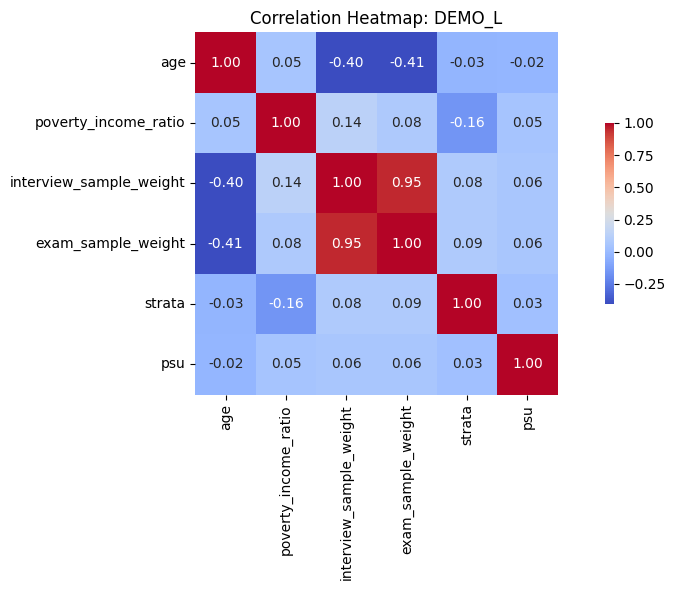

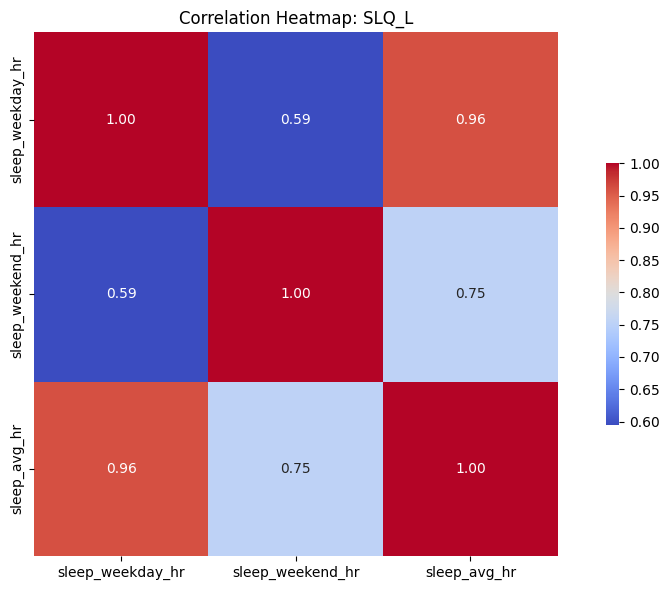

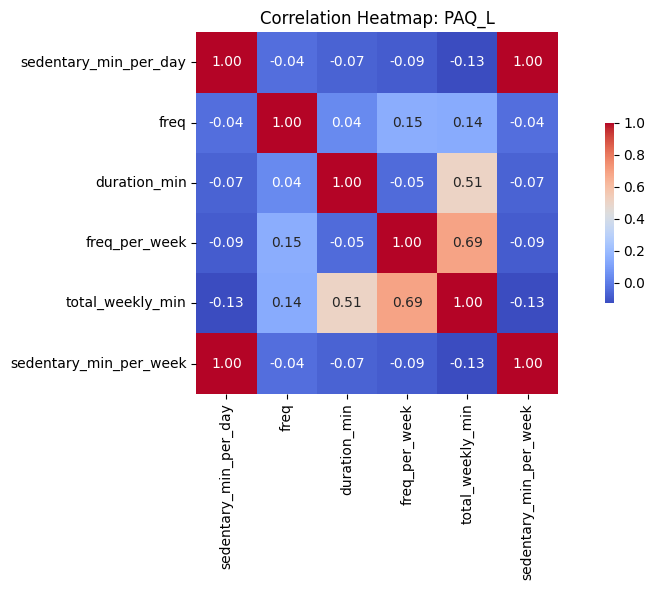

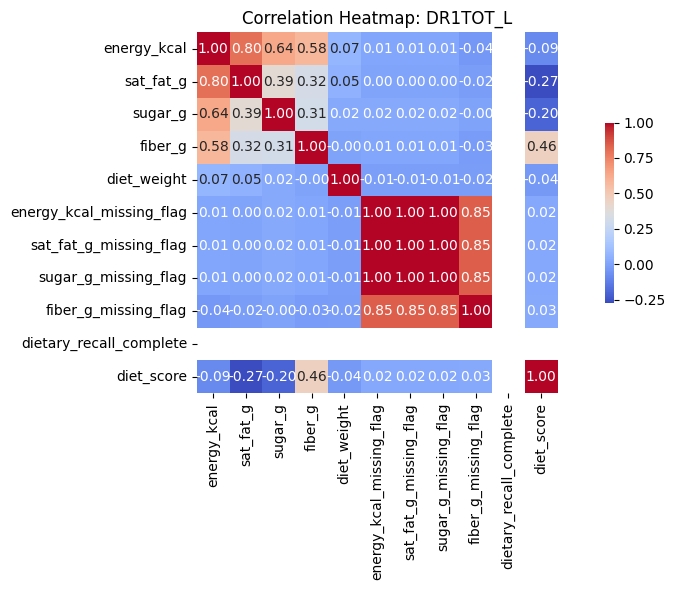

Skipping HIQ_L (not enough numeric columns).


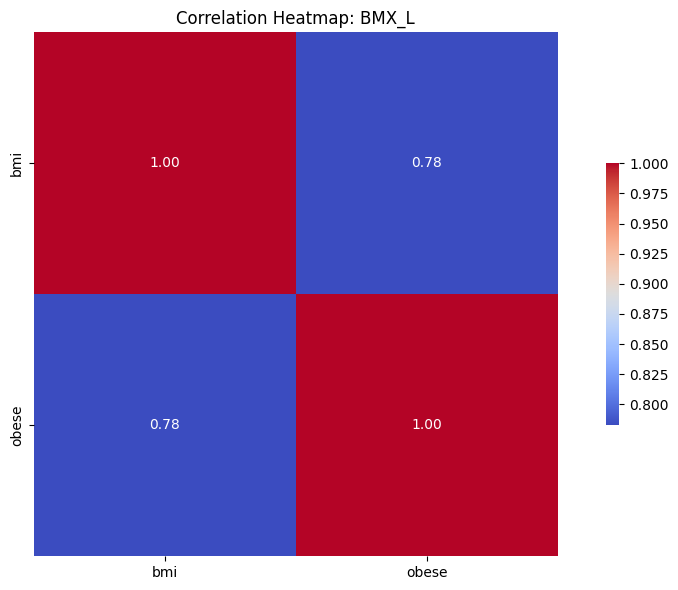

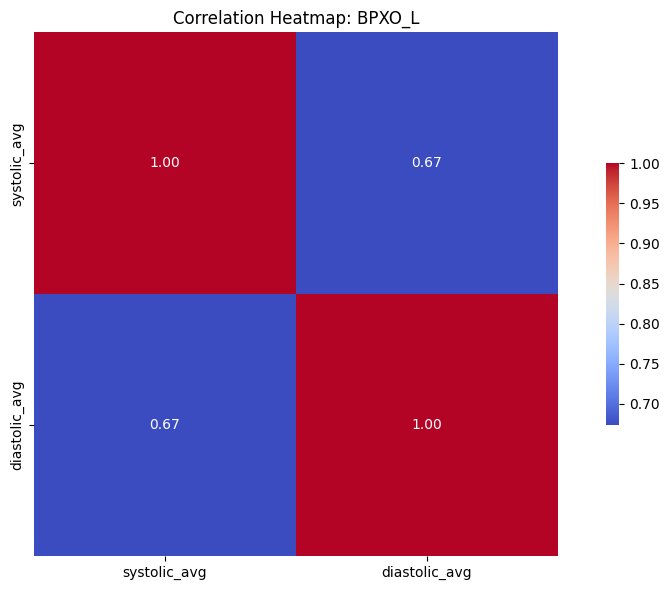

Skipping TCHOL_L (not enough numeric columns).


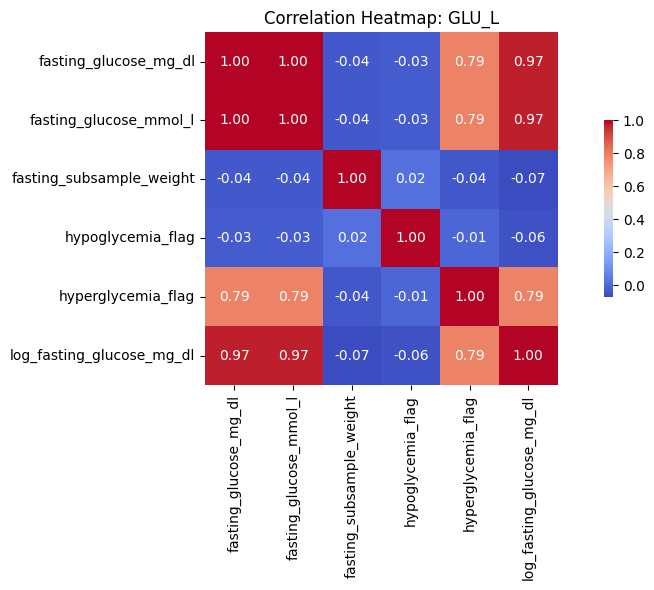

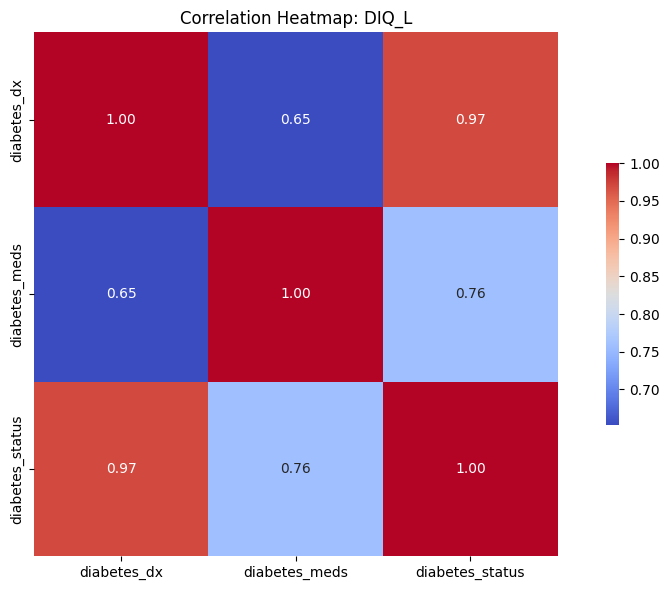

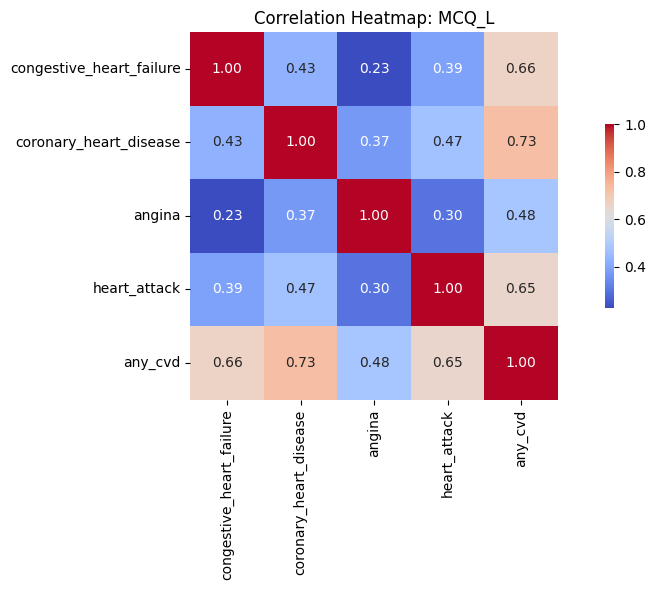

Saved all processed data heatmaps to outputs\plots\processed_data_correlation_heatmaps.pdf


In [10]:

# Create directory if missing
PLOTS_DIR.mkdir(parents=True, exist_ok=True)  

pdf_path = PLOTS_DIR / "processed_data_correlation_heatmaps.pdf"

with PdfPages(pdf_path) as pdf:
    for name, df in processed_data.items():
        numeric_df = df.select_dtypes(include=[np.number])
        if numeric_df.shape[1] < 2:
            print(f"Skipping {name} (not enough numeric columns).")
            continue

        plt.figure(figsize=(10, 6))
        sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={'shrink': .5})
        plt.title(f"Correlation Heatmap: {name}")
        plt.tight_layout()

        pdf.savefig()
        plt.show()
        plt.close()

print(f"Saved all processed data heatmaps to {pretty_path(pdf_path)}")